To download the dataset follow the instructions here:
- https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data?select=members.csv.7z

If you are running archlinux:
- git clone https://aur.archlinux.org/kaggle-api.git
- cd kaggle-api
- makepkg -si
- Go to the first link and create a kaggle account and agree to the competition rules
- go to your account page on kaggle and create an api key and save the kaggle.json file in the folder ~/.kaggle/
- kaggle competitions download -c kkbox-music-recommendation-challenge

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.data as tfd


from loguru import logger
from tqdm import tqdm

from typing import List, Any, Tuple, Optional, Dict

In [2]:
datapath: str = os.path.join('..', 'data')

In [3]:
def list_files(directory: str, extension: str) -> List[str]:
    all_files = os.listdir(directory)
    return [os.path.join(directory, file) for file in all_files if file.split('.')[-1] == extension]

In [4]:
datasets: Dict[str, pd.DataFrame] = dict()
for filepath in tqdm(list_files(datapath, 'csv'), ascii=True, desc="Loading data from disk"):
    datasets[os.path.basename(filepath).split('.')[0]] = pd.read_csv(filepath)

Loading data from disk: 100%|############################################################| 6/6 [00:16<00:00,  2.83s/it]


In [5]:
print(f"Loaded {len(datasets)} csv files")
for key, value in datasets.items():
    print(f"length of dataset {key} is {len(value)}")

Loaded 6 csv files
length of dataset members is 34403
length of dataset sample_submission is 2556790
length of dataset songs is 2296320
length of dataset song_extra_info is 2295971
length of dataset test is 2556790
length of dataset train is 7377418


In [6]:
# Let's remove the 'sample_submission' dataset
_ = datasets.pop('sample_submission')

In [7]:
for key, value in datasets.items():
    print(f"Information for dataset: {key}")
    print("Description")
    print(value.describe())
    print('\n')
    print("dataframe 'head'")
    print(value.head())
    print('\n\n-------------------------------------------------------\n\n')

Information for dataset: members
Description
               city            bd  registered_via  registration_init_time  \
count  34403.000000  34403.000000    34403.000000            3.440300e+04   
mean       5.371276     12.280935        5.953376            2.013994e+07   
std        6.243929     18.170251        2.287534            2.954015e+04   
min        1.000000    -43.000000        3.000000            2.004033e+07   
25%        1.000000      0.000000        4.000000            2.012103e+07   
50%        1.000000      0.000000        7.000000            2.015090e+07   
75%       10.000000     25.000000        9.000000            2.016110e+07   
max       22.000000   1051.000000       16.000000            2.017023e+07   

       expiration_date  
count     3.440300e+04  
mean      2.016901e+07  
std       7.320925e+03  
min       1.970010e+07  
25%       2.017020e+07  
50%       2.017091e+07  
75%       2.017093e+07  
max       2.020102e+07  


dataframe 'head'
                 

### In English:
- we have a list of users, their personal information, the songs that they liked and didnt like, and where they accesed the song
- we also have metadata about each song in the dataset
- the dataframe describe function seems to have bugged out with jupyter lab and not shown all of the columns, so I also printed the "heads" of each dataframe

# The first task is creating one dataframe that can hold all of our song information robustly
# And another which can handle our user data robustly
If your data contains both numeric and categorical variables, the best way to carry out clustering on the dataset is to create principal components of the dataset and use the principal component scores as input into the clustering.

Remember that u can always get principal components for categorical variables using a multiple correspondence analysis (MCA), which will give principal components, and you can get then do a separate PCA for the numerical variables, and use the combined as input into your clustering.

OR u could use the R package called FactorMineR or PCAmix to carry Factor analysis of mixed data, with the output being principal components, and then using the principal components as input into your clustering.

Remember that clustering and principal components are doing almost similar thing in a simplistic way they're both distances, e.g Euclidean distance.

Dataset descriptions:
- members.csv
    - user ID, location, gender, 
- song_extra_info + songs.csv
    - song_id, song name, artist name, composer, lyricist, genre id, song length, language
- train.csv:
    - userid, songid, where they found the song, whether they liked it or now
    

Task theoreticals:
    theoretical:
        cluster by attributes and label by userid. i.e each datapoint is a user with a certain value assigned
    practical:
        difficult as some of the most important information is artist and composer and its hard to assign a numercal value to those attributes with the information at hand
  
  
    - theoretical
        - create an embedding between the userid, songid, composers, and how the user is realted to the song
        - cluster on the embedding
        
        
        
        
        
    - theoretical
        - do principal component analysis (MCA) on the categorical variables and then do another PCA on the numerical vairables, use this as the combined input to a clustering algorithm ( possibly spectral becuase of the most probably complex but ordered topology of the datase ) and then recommend users songs from the clusters they are interested in 
    - practical
        - could end up recommending too many songs but we can tune the "looking distance" of the final recommender
        
EITHER CLUSTER THE SONGS AND THEN DO A SECONDARY PROCESS TO RECOMMEDN TO USERS OR CLUSTER THE USERS AND RECOMMEND ENTIRE LIBRARIES
New Dataset:
- categorical:
    - artist name, composer, lyricist, genre_id, language
- numerical:
    - song length
- label:
    - song id
    
This will be used to create clusters of songs, or song groups

Recommendation dataset:
- userid, song rating, songs cluster, songs feature vector, 

In [356]:
len(datasets['songs'])
datasets["songs"]

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),NaN,NaN,3.0
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,NaN,NaN,52.0
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,NaN,NaN,52.0


In [404]:
raw = pd.DataFrame()
# categorical variables
raw["artist_name"] = datasets["songs"]["artist_name"]
raw["composer"] = datasets["songs"]["composer"] 
raw["lyricist"] = datasets["songs"]["lyricist"]
raw["genre_id"] = datasets["songs"]["genre_ids"]
raw["language"] = datasets["songs"]["language"]
raw["song_length"] = datasets["songs"]["song_length"]

In [405]:
raw

,artist_name,composer,lyricist,genre_id,language,song_length
0,張信哲 (Jeff Chang),董貞,何啟弘,465,3.0,247640
1,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,444,31.0,197328
2,SUPER JUNIOR,NaN,NaN,465,31.0,231781
3,S.H.E,湯小康,徐世珍,465,3.0,273554
4,貴族精選,Traditional,Traditional,726,52.0,140329
...,...,...,...,...,...,...
2296315,Catherine Collard,Robert Schumann (1810-1856),NaN,958,-1.0,20192
2296316,紀文惠 (Justine Chi),NaN,NaN,465,3.0,273391
2296317,Various Artists,NaN,NaN,1609,52.0,445172
2296318,Peter Paul & Mary,NaN,NaN,465,52.0,172669


In [406]:
import re

def only_letters(tested_string):
    match = re.match("^[a-zA-Z]*$", str(tested_string))
    return match is not None
def only_numbers(tested_string):
    match = re.match("^[0-9]*$", str(tested_string))
    return match is not None

In [407]:
raw['artist_name'] = raw[raw['artist_name'].apply(only_letters)]
raw['lyricist'] = raw[raw['lyricist'].apply(only_letters)]
raw['composer'] = raw[raw['composer'].apply(only_letters)]
raw['genre_id'] = raw[raw['genre_id'].apply(only_numbers)]

We are working with a truly massive dataset, and to allocate enough memory to run an MCA on even just raw cat would take over 1.4 TiB
so lets drop everything with an NA

In [408]:
raw.dropna(axis=0, how='any', inplace=True)

In [409]:
raw

,artist_name,composer,lyricist,genre_id,language,song_length
32,HUSH,HUSH,HUSH,HUSH,3.0,342144
110,Paramore,Paramore,Paramore,Paramore,52.0,247455
132,Pitbull,Pitbull,Pitbull,Pitbull,52.0,245852
141,Yiruma,Yiruma,Yiruma,Yiruma,-1.0,264211
154,ABBA,ABBA,ABBA,ABBA,52.0,267354
...,...,...,...,...,...,...
2296265,Luna,Luna,Luna,Luna,52.0,220577
2296275,Piaf,Piaf,Piaf,Piaf,52.0,204056
2296278,Slowdown,Slowdown,Slowdown,Slowdown,-1.0,292107
2296286,Plej,Plej,Plej,Plej,-1.0,309568


In [410]:
raw = raw[(raw.artist_name != 'Various Artists') & (raw.artist_name != 'Various')]
raw = raw[raw.language != -1]

One other way to reduce the number of categories for MCA is to filter our dataframe by the top 1000 artists

In [412]:
num_artists=80
num_composers=200
num_lyricists=200
num_genres=200
num_languages=3

In [413]:
raw

,artist_name,composer,lyricist,genre_id,language,song_length
32,HUSH,HUSH,HUSH,HUSH,3.0,342144
110,Paramore,Paramore,Paramore,Paramore,52.0,247455
132,Pitbull,Pitbull,Pitbull,Pitbull,52.0,245852
154,ABBA,ABBA,ABBA,ABBA,52.0,267354
179,Swifty,Swifty,Swifty,Swifty,52.0,209536
...,...,...,...,...,...,...
2296234,Koinonia,Koinonia,Koinonia,Koinonia,52.0,172930
2296264,Calum,Calum,Calum,Calum,52.0,196545
2296265,Luna,Luna,Luna,Luna,52.0,220577
2296275,Piaf,Piaf,Piaf,Piaf,52.0,204056


In [414]:
raw = raw[raw.artist_name.isin(raw['artist_name'].value_counts(sort=True).index.tolist()[:num_artists])]
raw = raw[raw.composer.isin(raw['composer'].value_counts(sort=True).index.tolist()[:num_composers])]
raw = raw[raw.lyricist.isin(raw['lyricist'].value_counts(sort=True).index.tolist()[:num_lyricists])]
raw = raw[raw.genre_id.isin(raw['genre_id'].value_counts(sort=True).index.tolist()[:num_genres])]
raw = raw[raw.language.isin(raw['language'].value_counts(sort=True).index.tolist()[:num_languages])]

In [415]:
raw

,artist_name,composer,lyricist,genre_id,language,song_length
132,Pitbull,Pitbull,Pitbull,Pitbull,52.0,245852
193,FTISLAND,FTISLAND,FTISLAND,FTISLAND,31.0,215040
221,Roxette,Roxette,Roxette,Roxette,52.0,226089
318,Westlife,Westlife,Westlife,Westlife,52.0,164490
325,ATB,ATB,ATB,ATB,52.0,367386
...,...,...,...,...,...,...
2294504,Christmas,Christmas,Christmas,Christmas,52.0,230620
2294521,Sade,Sade,Sade,Sade,52.0,315001
2294687,Seal,Seal,Seal,Seal,52.0,285779
2294703,Chicago,Chicago,Chicago,Chicago,52.0,386194


In [416]:
raw.artist_name.unique()

array(['Pitbull', 'FTISLAND', 'Roxette', 'Westlife', 'ATB', 'Oasis',
       'Aerosmith', 'Placebo', 'Muse', 'America', 'CNBLUE', 'SCANDAL',
       'Disturbed', 'YUI', 'Madonna', 'Sting', 'Prince', 'EXILE',
       'BIGBANG', 'SHINee', 'Europe', 'Shinedown', 'Train', 'STARS',
       'Shakira', 'Toto', 'Chic', 'BoA', 'Enya', 'Korn', 'Tyga', 'Moby',
       'Planetshakers', 'supercell', 'Sade', 'Eagles', 'McFly', 'Journey',
       'Jewel', 'Zia', 'Hardwell', 'Instrumental', 'TLC', 'Santana',
       'Halestorm', 'Migos', 'DEPAPEPE', 'Foreigner', 'SMTOWN', 'Kaskade',
       'Seal', 'Eels', 'AAA', 'Christmas', 'Jamiroquai', 'Phoenix',
       'Chicago', 'Jazz', 'Cher', 'Stereolab', 'Helloween', 'Mogwai',
       'Fitnessbeat', 'otetsu', 'Cascada', 'Heart', 'Deftones', 'Pantera',
       'Garbage', 'Wilco', 'Babyface', 'Usher', 'Suede', 'Beyond',
       'Oddisee', 'Vangelis', 'Funk', 'Blues'], dtype=object)

In [417]:
raw.composer.unique()

array(['Pitbull', 'FTISLAND', 'Roxette', 'Westlife', 'ATB', 'Oasis',
       'Aerosmith', 'Placebo', 'Muse', 'America', 'CNBLUE', 'SCANDAL',
       'Disturbed', 'YUI', 'Madonna', 'Sting', 'Prince', 'EXILE',
       'BIGBANG', 'SHINee', 'Europe', 'Shinedown', 'Train', 'STARS',
       'Shakira', 'Toto', 'Chic', 'BoA', 'Enya', 'Korn', 'Tyga', 'Moby',
       'Planetshakers', 'supercell', 'Sade', 'Eagles', 'McFly', 'Journey',
       'Jewel', 'Zia', 'Hardwell', 'Instrumental', 'TLC', 'Santana',
       'Halestorm', 'Migos', 'DEPAPEPE', 'Foreigner', 'SMTOWN', 'Kaskade',
       'Seal', 'Eels', 'AAA', 'Christmas', 'Jamiroquai', 'Phoenix',
       'Chicago', 'Jazz', 'Cher', 'Stereolab', 'Helloween', 'Mogwai',
       'Fitnessbeat', 'otetsu', 'Cascada', 'Heart', 'Deftones', 'Pantera',
       'Garbage', 'Wilco', 'Babyface', 'Usher', 'Suede', 'Beyond',
       'Oddisee', 'Vangelis', 'Funk', 'Blues'], dtype=object)

In [418]:
raw.lyricist.unique()

array(['Pitbull', 'FTISLAND', 'Roxette', 'Westlife', 'ATB', 'Oasis',
       'Aerosmith', 'Placebo', 'Muse', 'America', 'CNBLUE', 'SCANDAL',
       'Disturbed', 'YUI', 'Madonna', 'Sting', 'Prince', 'EXILE',
       'BIGBANG', 'SHINee', 'Europe', 'Shinedown', 'Train', 'STARS',
       'Shakira', 'Toto', 'Chic', 'BoA', 'Enya', 'Korn', 'Tyga', 'Moby',
       'Planetshakers', 'supercell', 'Sade', 'Eagles', 'McFly', 'Journey',
       'Jewel', 'Zia', 'Hardwell', 'Instrumental', 'TLC', 'Santana',
       'Halestorm', 'Migos', 'DEPAPEPE', 'Foreigner', 'SMTOWN', 'Kaskade',
       'Seal', 'Eels', 'AAA', 'Christmas', 'Jamiroquai', 'Phoenix',
       'Chicago', 'Jazz', 'Cher', 'Stereolab', 'Helloween', 'Mogwai',
       'Fitnessbeat', 'otetsu', 'Cascada', 'Heart', 'Deftones', 'Pantera',
       'Garbage', 'Wilco', 'Babyface', 'Usher', 'Suede', 'Beyond',
       'Oddisee', 'Vangelis', 'Funk', 'Blues'], dtype=object)

In [419]:
raw.genre_id.unique()

array(['Pitbull', 'FTISLAND', 'Roxette', 'Westlife', 'ATB', 'Oasis',
       'Aerosmith', 'Placebo', 'Muse', 'America', 'CNBLUE', 'SCANDAL',
       'Disturbed', 'YUI', 'Madonna', 'Sting', 'Prince', 'EXILE',
       'BIGBANG', 'SHINee', 'Europe', 'Shinedown', 'Train', 'STARS',
       'Shakira', 'Toto', 'Chic', 'BoA', 'Enya', 'Korn', 'Tyga', 'Moby',
       'Planetshakers', 'supercell', 'Sade', 'Eagles', 'McFly', 'Journey',
       'Jewel', 'Zia', 'Hardwell', 'Instrumental', 'TLC', 'Santana',
       'Halestorm', 'Migos', 'DEPAPEPE', 'Foreigner', 'SMTOWN', 'Kaskade',
       'Seal', 'Eels', 'AAA', 'Christmas', 'Jamiroquai', 'Phoenix',
       'Chicago', 'Jazz', 'Cher', 'Stereolab', 'Helloween', 'Mogwai',
       'Fitnessbeat', 'otetsu', 'Cascada', 'Heart', 'Deftones', 'Pantera',
       'Garbage', 'Wilco', 'Babyface', 'Usher', 'Suede', 'Beyond',
       'Oddisee', 'Vangelis', 'Funk', 'Blues'], dtype=object)

In [422]:
import prince
famd = prince.FAMD(
    n_components=3,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
famd = famd.fit(raw.drop('artist_name', axis='columns'))

In [423]:
famd.row_coordinates(raw).isna().sum()

0    0
1    0
2    0
dtype: int64

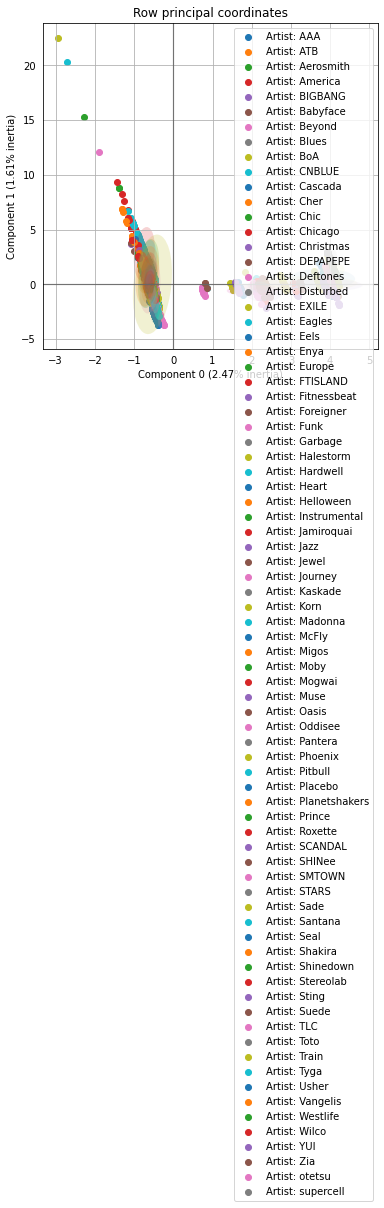

In [426]:
ax = famd.plot_row_coordinates(
    X = raw,
    ax=None,
    figsize=(6,6),
    x_component=0,
    y_component=1,
    color_labels=["Artist: {}".format(t) for t in raw["artist_name"]],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True
)

In [425]:
ax.get_figure().savefig('famd_row_coordinates.svg')